In [252]:
import numpy as np
import matplotlib.pyplot as plt

In [253]:
class Data_generator:
    def __init__(self, _alpha_r=0, _beta_r=1, _d=1, _alpha_u=0, _beta_u=1, _gamma=1, _theta=0, __lambda=1):
        self.alpha_r = _alpha_r
        self.beta_r = _beta_r
        self.d = _d
        self.alpha_u = _alpha_u
        self.beta_u = _beta_u
        self.gamma = _gamma
        self.theta = _theta
        self._lambda = __lambda

    def gen_data(self, n=1000, T=100):
        r=np.zeros((T,n)) #r yield
        eps=np.zeros(n)
        u=np.zeros(n)
        for i in range(T):
            u = self.alpha_u+self.beta_u*u+self.gamma*eps**2+self.theta*np.where(eps<0,eps**2,0)+np.random.exponential(scale=1/self._lambda,size=n)
            eps=np.random.standard_t(df=self.d, size=n)*np.sqrt(u)
            r[i]=self.alpha_r+self.beta_r*u+eps
        return r
    
    def gen_data_full(self, n=1000, T=100):
        r=np.zeros((T,n)) #r yield
        eps_list=np.zeros((T,n))
        u_list=np.zeros((T,n))
        u=np.zeros(n)
        eps=np.zeros(n)
        r[0]=self.alpha_r
        for i in range(1, T):
            u = self.alpha_u+self.beta_u*u+self.gamma*eps**2+self.theta*np.where(eps<0,eps**2,0)+np.random.exponential(scale=1/self._lambda,size=n)
            eps=np.random.standard_t(df=self.d, size=n)*np.sqrt(u)
            u_list[i]=u
            eps_list[i]=eps
            r[i]=self.alpha_r+self.beta_r*u+eps
        return r, u_list, eps_list
    
    
    
#DG = Data_generator(0.2, 0.2, 6.0, 0.6, 0.4, 0.1, 0.02, 2.5)
#print(DG.gen_data_full(5, 5))    
#Test texts

In [254]:
params = (0.2, 0.2, 6.0, 0.6, 0.4, 0.1, 0.02, 2.5)

In [290]:
T = 3
DG = Data_generator(*params)
data = DG.gen_data_full(10000, T)

In [291]:
import numpy as np
from scipy.stats import t, expon


def updaterr(r_t, eps_t, r_t1, eps_t1, alpha_r, beta_r, d, alpha_u, beta_u, gamma, theta, _lambda):
    u_t1 = (r_t1 - alpha_r - eps_t1) / beta_r
    w_t = alpha_u + beta_u * u_t1 + gamma * eps_t1 ** 2 + theta * (eps_t1 < 0) * eps_t1 ** 2
    nu_t = eps_t * np.sqrt(beta_r / (r_t - eps_t - alpha_r))
    eta_t = (r_t - eps_t - alpha_r) / beta_r - w_t
    p = t.pdf(nu_t, d) * expon.pdf(eta_t, scale=1 / _lambda) / np.sqrt(beta_r * (r_t - eps_t - alpha_r))
    return p

In [292]:
class TEST_SAMPLER:
    """test sampler"""
    ESS_list = []
    sample_num = 1
    def __init__(self, T, params):
        self.alpha_r, self.beta_r, self.d, self.alpha_u, self.beta_u,self.gamma, self.theta, self._lambda = params
        self.params = params
        self.T = T 

    def log_likelihood_update(self,epsilon,r,epsilon_past,r_past):
        ''' Compute log joint likelihood of l=log p(eps_t,r_t|eps_{t-1},r_{t-1})'''
        #Input:  epsilon  (n,) epsilon_past  (n,)  r (1,) r_past (1,)
        #Output: log_prob (n,)

        prior=0 #do we need prior on r_0, eps_0?

        ''' Calculate u, w, nu and eta'''
        #u=(r-epsilon-self.alpha_r)/self.beta_r
        u_past= (r_past-epsilon_past-self.alpha_r)/self.beta_r

        w=self.alpha_u+self.beta_u*u_past+(self.gamma+self.theta*(epsilon_past<0))*(epsilon_past**2)

        nu=np.sqrt(self.beta_r/(r-epsilon-self.alpha_r))*epsilon
        eta=(r-epsilon-self.alpha_r)/self.beta_r-w
        #print(f"eps:{epsilon[:10]}\n eps_past:{epsilon_past[:10]}\n r:{r} r_past:{r_past} etamin:{eta.min()}\n w:{w[:10]}, nu:{nu[:10]}\n eta:{eta[:10]}\n")
        #assert eta.min()>0 #eta should follow exponential distribution
        logp_exp=expon.logpdf(eta, scale=1/self._lambda)
        logp_t=t.logpdf(nu,self.d)


        log_joint=logp_exp+logp_t -0.5*(np.log(self.beta_r)+np.log(r-epsilon-self.alpha_r))+prior
        #print(log_joint)
        return log_joint
        
    def sample(self, sample_num:int, r, exp_scale=1, resample_thre=0.2):
        self.ESS_list = []
        self.sample_num = sample_num
        
        samples = np.zeros((sample_num,self.T))
        log_weights = np.ones(sample_num)
        eps=np.zeros(sample_num)
        r_past=self.alpha_r
        for i in range(self.T): 
            rr=r[i]
            eps_past=eps.copy()
            eps = self.policy(eps_past, rr, r_past, exp_scale)
            log_weights += self.log_likelihood_update(eps,rr,eps_past,r_past)-self.log_policy_density(eps, eps_past, rr, r_past, exp_scale)
            r_past=rr
            samples[:,i]=eps
            weights=np.exp(log_weights)
            weights=weights/weights.sum()
            
            ESS = 1/np.sum(np.power(weights, 2))
            self.ESS_list.append(ESS)
            if ESS < resample_thre*sample_num:
                samples[:,i] = self.resample(samples[:,i], weights)
                weights = np.ones(sample_num)
                log_weights=np.zeros(sample_num)
        return samples, weights
    
    def plot_ESS(self, y_high=0, title=""):
        if y_high == 0:
            y_high = self.sample_num
        plt.plot(range(self.T), self.ESS_list)
        plt.ylim(0, y_high)
        plt.xlim(0, self.T)
        plt.ylabel("ESS")
        if title != "":
            plt.title(title)
        plt.show()
        plt.clf()
    
    def resample(self, samples, weights):
        index = np.random.choice(list(range(len(weights))), p=weights, size=(len(weights)))
        return samples[index]
    
    def policy(self, et1:np.array, rt, rt1, exp_scale):
        return rt-self.alpha_r-np.random.exponential(scale=exp_scale,size=self.sample_num) #a simple policy
    
    def log_policy_density(self, et:np.array, et1:np.array, rt, rt1, exp_scale):
        return expon.logpdf(rt- self.alpha_r - et, scale=exp_scale)

In [293]:
sampler = TEST_SAMPLER(T, params)

In [294]:
samples, weights = sampler.sample(10000, data[0], exp_scale=2)

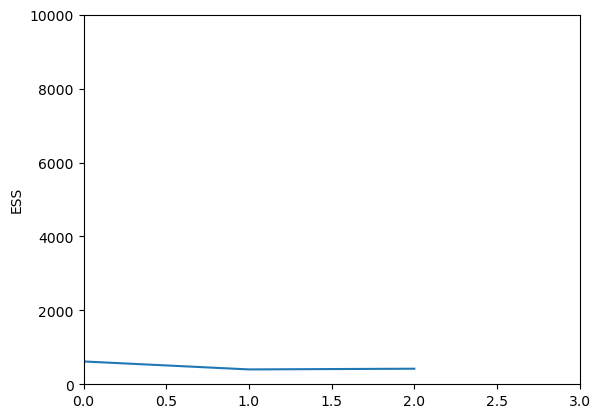

<Figure size 640x480 with 0 Axes>

In [295]:
sampler.plot_ESS()

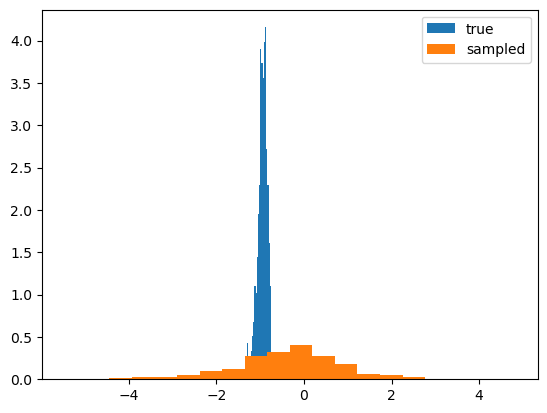

In [296]:
index = (data[0][T-1]>data[0][T-1][0]-0.1)&(data[0][T-1]<data[0][T-1][0]+0.1)
plt.hist((data[2][T-1])[index], density=True, bins=20, label="true")
plt.hist(samples[:,T-1], weights=weights, density=True, bins=20, label="sampled")
plt.legend()
plt.show()

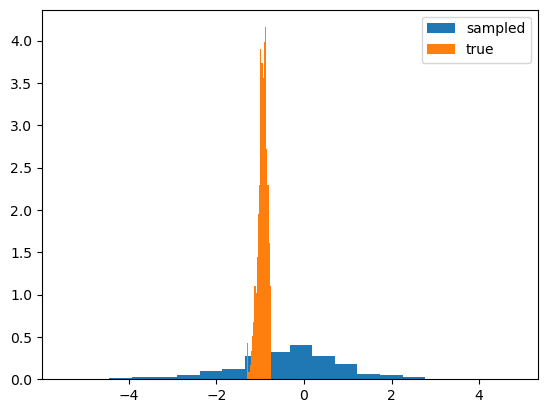

In [297]:
plt.hist(samples[:,T-1], weights=weights, density=True, bins=20, label="sampled")
index = (data[0][T-1]>data[0][T-1][0]-0.1)&(data[0][T-1]<data[0][T-1][0]+0.1)
plt.hist((data[2][T-1])[index], density=True, bins=20, label="true")
plt.legend()
plt.show()

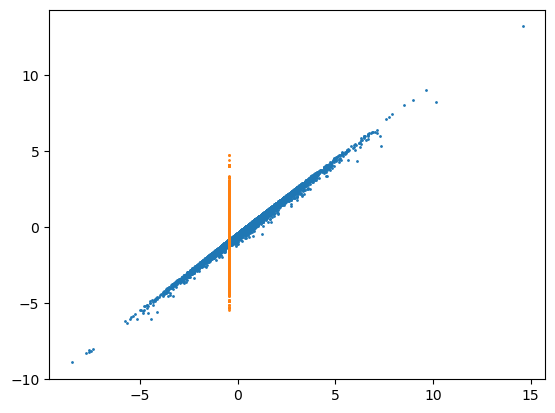

In [298]:
index = np.random.choice(list(range(10000)), p=weights/10000, size=(10000))
plt.scatter(data[0][T-1], data[2][T-1], s=1)
plt.scatter([data[0][T-1][0]]*10000, (samples[:,T-1])[index], s=1)
plt.show()